## Name: Parham Bateni
## Student number: 99105294

In this notebook we would like to simulate the page rank algorithm which is used in browsers search engines by using markov chains.
The goal is to predict the final probability of user being in each different page.

First we get the inputs.
In thi first line the number of pages is given. Then in the next line the initial probability of the states are given. Finally the transition matrix which is a $n\times n$ matrix is given in the next n lines.

In [ ]:
%pip install ipympl
%pip install matplotx

In [276]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt,cm
import ipympl
import matplotx
plt.style.use(matplotx.styles.dracula)
from matplotlib.ticker import LinearLocator

In [13]:
def get_inputs():
    number_pages=int(input())
    initial_probs=list(map(float,input().split()))
    transition_matrix=np.array([list(map(float,input().split())) for _ in range(number_pages)])
    return number_pages,initial_probs,transition_matrix

In [16]:
number_pages,initial_probs,transition_matrix=get_inputs()
transition_matrix

3
0 0 1
0.3 0.2 0.5
0.4 0.3 0.3
0.3 0.4 0.3


array([[0.3, 0.2, 0.5],
       [0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3]])

# A)
First we find the stationary probabilities or in other words the probability of being in state $i$ when $t \rightarrow \infty$:
$$ \lim_{t \rightarrow \infty}P(X_t=i)$$

In [156]:
def simulate(number_pages,initial_probs,transition_matrix,n=3000,t=500,show_tqdm=True):
    experiments=[]
    state_space=np.arange(number_pages)
    for _ in tqdm(range(n),'Simulating...',disable=~show_tqdm):
        current_state=np.random.choice(state_space,p=initial_probs)
        for __ in range(t):
            current_state=np.random.choice(state_space,p=transition_matrix[current_state])
        experiments.append(current_state)
    return np.array([np.mean(np.array(experiments)==i) for i in range(number_pages)])
        

In [129]:
simulated_probs=simulate(number_pages,initial_probs,transition_matrix)

Simulating...: 100%|██████████████████████████████████████████████████████████████| 3000/3000 [00:27<00:00, 108.87it/s]


In [130]:
print('The stationary probability of states:')
print(np.round(simulated_probs,3))

The stationary probability of states:
[0.327 0.317 0.356]


# B)
Now we investigate the influence of the number of steps in each simulation and the number of simulations on the accuracy of the stationary probabilities predicted

First we need to know find the actual answers. According to the slides of the course, we have:
$$ P(X_t) = P(X_0) \times (transition \space matrix)^t$$

In [89]:
def compute_stationary_probs(initial_probs,transition_matrix,steps=500):
    return initial_probs@np.linalg.matrix_power(transition_matrix,steps)

real_probs=compute_stationary_probs(initial_probs,transition_matrix)
real_probs

array([0.33035714, 0.30357143, 0.36607143])

We also need an accuracy metric to evaluate the simulation. So here we use Jensen–Shannon divergence.

$$ JSD(P,Q)= \frac{1}{2}\times D_{KL}(P,M) + \frac{1}{2}\times D_{KL}(Q,M)$$
<br>
Where $M=\frac{P+Q}{2}$ and $D_{KL}$ is Kullback–Leibler divergence:
$$D_{KL}(p,q) =  \sum_{i=1}^{n}{p_i \times \log{\frac{p_i}{q_i}}} $$

In [173]:
def KL_divergence(p:np.array,q:np.array):
    return np.dot(p,np.log(p/q))
def JS_divergence(p:np.array,q:np.array):
    m=(p+q)/2
    return 1/2*KL_divergence(p,m)+1/2*KL_divergence(q,m)
print(f'JS divergence of the real and simulated probablities:',JS_divergence(real_probs,simulated_probs))

JS divergence of the real and simulated probablities: 0.00010772159473450239


As you can see the real probabilites are somehow near the ones we found in part A which number of simulations=3000 and steps=500.
<br>
Now we evaluate the simulations' results with different number of simulations and steps. First we see the effect of these parameters on the results separately and then we see their effect with each other.

In [183]:
number_simulations=np.arange(100,2001,100)
divergences_per_number_simulations=[]
for number_simulation in tqdm(number_simulations,'Simulating for different number of simulations...'):
    divergences_per_number_simulations.append(JSD_divergence(real_probs,simulate(number_pages,initial_probs,transition_matrix,n=number_simulation,t=100,show_tqdm=False)))

Simulating for different number of simulations...: 100%|███████████████████████████████| 20/20 [00:37<00:00,  1.88s/it]


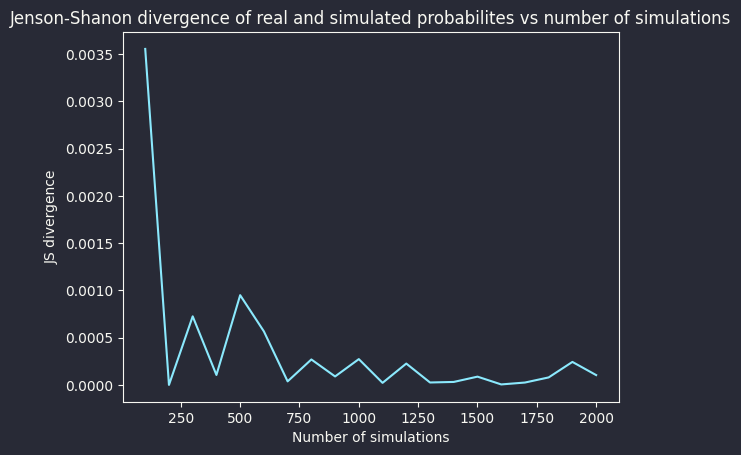

In [184]:
plt.style.use(matplotx.styles.dracula)
plt.title('Jenson-Shanon divergence of real and simulated probabilites vs number of simulations')
plt.xlabel('Number of simulations')
plt.ylabel('JS divergence')
plt.plot(steps,divergences_per_number_simulations)
plt.show()

As the given plot shows by increasing just the number of simulations the JS divergence of the simulated and real stationary probabilites decreases and it somehow converges to a number very near 0.

In [220]:
steps=np.arange(10,601,30)
divergences_per_steps=[]
for step in tqdm(steps,'Simulating for different steps...'):
    divergences_per_steps.append(JSD_divergence(real_probs,simulate(number_pages,initial_probs,transition_matrix,n=500,t=step,show_tqdm=False)))

Simulating for different steps...: 100%|███████████████████████████████████████████████| 20/20 [00:50<00:00,  2.53s/it]


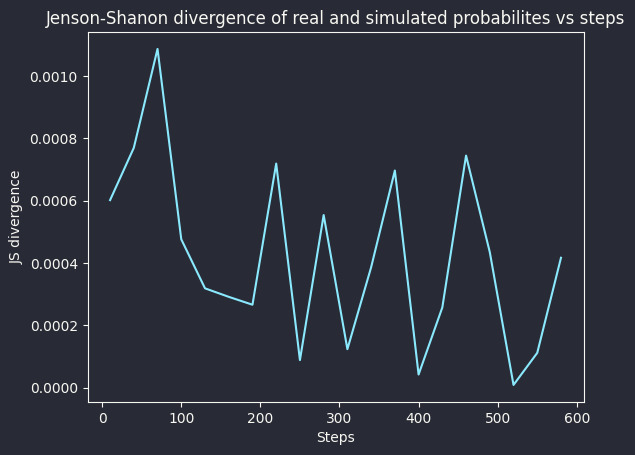

In [221]:
plt.title('Jenson-Shanon divergence of real and simulated probabilites vs steps')
plt.xlabel('Steps')
plt.ylabel('JS divergence')
plt.plot(steps,divergences_per_steps)
plt.show()

It can be seen from the given plot that the divergence mostly saturates when increasing just the steps, but the overall trend is downward.

Now we see the effect of changing both steps and the number of simulations on the JS divergence between simulated and real stationary probabilities.
<br>
The following cell takes about 3 minutes to run, don't worry :)

In [336]:
steps=np.arange(210,401,20)
number_simulations=np.arange(210,401,20)
parameters=[(x,y) for x in steps for y in number_simulations]

X,Y=np.meshgrid(steps,number_simulations)
Z=np.zeros((len(steps),len(number_simulations)))
for i in tqdm(range(len(steps)),'Simulating for different steps and different number of simulations...'):
    for j in range(len(number_simulations)):
        Z[i,j]=JS_divergence(real_probs,simulate(number_pages,initial_probs,transition_matrix,n=number_simulations[j],t=steps[i],show_tqdm=False))

Simulating for different steps different number of simulations...: 100%|███████████████| 10/10 [02:48<00:00, 16.86s/it]


Drag to rotate the 3D plot :)


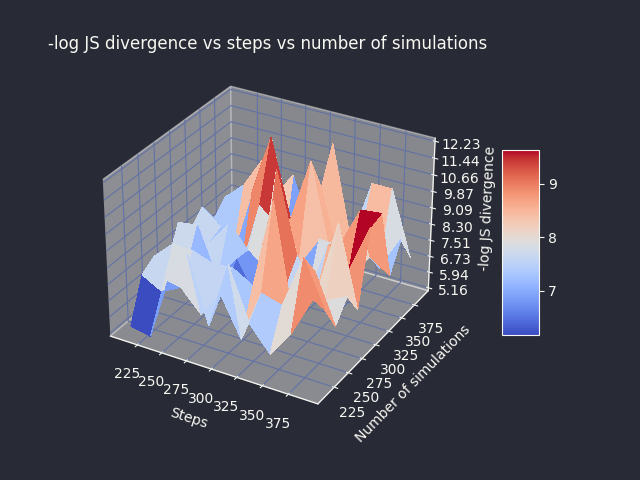

In [341]:
%matplotlib widget
print('Drag to rotate the 3D plot :)')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, -np.log(Z), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_zlabel('-log JS divergence')
fig.colorbar(surf, shrink=0.5, aspect=5,location='right',pad=0.1)
plt.title('-log JS divergence vs steps vs number of simulations')
plt.xlabel('Steps')
plt.ylabel('Number of simulations')
plt.show()

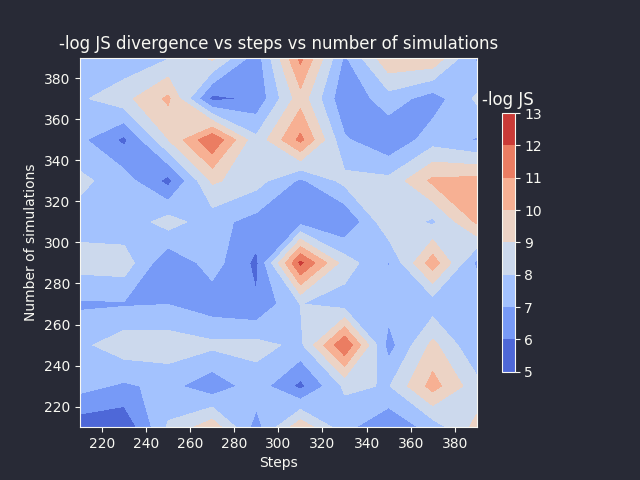

In [366]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, -np.log(Z),cmap=plt.cm.coolwarm)
clb=fig.colorbar(cp,shrink=0.7)
clb.ax.set_title('-log JS')
ax.set_title('-log JS divergence vs steps vs number of simulations')
ax.set_xlabel('Steps')
ax.set_ylabel('Number of simulations')
plt.show()

In the previous 3D plots we plotted the -log JS divergence for different combinations of number of steps and simulations.
The higher the -log JS divergence the better the less diverged the simulated probabilites are from the real probabilites.
So the points with higher -log JS were appropriate points for the simualtions parameters. For example taking the steps to be near 310 and the number of simulations to be near 300 we get the best result from the simulation. Note that we could only test a limited combination of parameters and also small parameters because otherwise it would take a lot time to simulate the whole process.
Overall with increasing the number of steps and the number of simulations the simulated stationary probabilites will become more alike to the real probabilites.